In [1]:
import os
import yaml
import shutil
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import logging
from PIL import Image
from datetime import datetime

import matplotlib.pyplot as plt

In [3]:
# Define config 
from types import SimpleNamespace   

cfg = {
# File:
    'task_type': 'image',
    'task_title': 'luna-',
    'result_directory': "./result/",
    'source_path': "./data/luna.jpg",
    'save_gt': True,

# Grid:
    'feature_dim': 2,
    'grid_dim': 2,
    'num_lvl': 16,
    'max_res': 1000,
    'min_res': 16,
    'hashtable_power': 18,
    'force_cpu': False,

# Decoder:
    'input_dim': 32,
    'output_dim': 3,
    'activation': "Relu",
    'last_activation': "Linear",
    'bias': True,
    'num_layer': 3,
    'hidden_dim': 64,
    'force_cpu': False,

# Trainer:
    'num_epoch': 5000,
    'batch_size': 10000,
    'range_clamping': True,
    'log_every': 100,
    'save_every': 500,
    'learning_rate': 0.001,
    'beta1': 0.9,
    'beta2': 0.99,
    'eps': 1e-15,
    'weight_decay': 1e-6,
    'force_cpu': False,
}

cfg = SimpleNamespace(**cfg)
cfg

namespace(task_type='image',
          task_title='luna-',
          result_directory='./result/',
          source_path='./data/luna.jpg',
          save_gt=True,
          feature_dim=2,
          grid_dim=2,
          num_lvl=16,
          max_res=1000,
          min_res=16,
          hashtable_power=18,
          force_cpu=False,
          input_dim=32,
          output_dim=3,
          activation='Relu',
          last_activation='Linear',
          bias=True,
          num_layer=3,
          hidden_dim=64,
          num_epoch=5000,
          batch_size=10000,
          range_clamping=True,
          log_every=100,
          save_every=500,
          learning_rate=0.001,
          beta1=0.9,
          beta2=0.99,
          eps=1e-15,
          weight_decay=1e-06)

# Def

In [4]:
# Function to get the current time as a formatted string
def get_time_str():
    now = datetime.now()  # Get the current date and time
    return now.strftime("%m%d%Y-%H%M%S")  # Format it as MMDDYYYY-HHMMSS


In [5]:

# Function to set up the result output directory and save the config as a YAML file
def setup_result_output(cfg):
    # Create a new result directory name by appending the current time to the task title
    new_result_dir_name = cfg.task_title + get_time_str()
    # Construct the full path for the new result directory
    new_result_dir = os.path.join(cfg.result_directory, new_result_dir_name)
    # Create the new result directory (and any necessary parent directories)
    os.makedirs(new_result_dir, exist_ok=True)
    # Update the result directory path in the config object
    cfg.result_directory = new_result_dir
    # Define the path for the new config file within the result directory
    new_config_file = os.path.join(cfg.result_directory, "result_config.yaml")
    # Convert the SimpleNamespace to a dictionary
    namespace_dict = vars(cfg)
    # Save the dictionary as a YAML file
    with open(new_config_file, "w") as file:
        yaml.dump(namespace_dict, file)

# Function to set up logging
def logging_setup(path):
    # Configure the logging settings
    logging.basicConfig(
        level=logging.INFO,  # Set the logging level to INFO
        filename=os.path.join(path, 'trainer.log'),  # Define the log file path
        filemode='w',  # Open the log file in write mode
        format='%(asctime)s|%(levelname)s| %(message)s'  # Define the log message format
    )


# Set up the result output directory and save the config
setup_result_output(cfg)
# Set up logging in the result directory
logging_setup(cfg.result_directory)


In [4]:
import torch
import torch.nn as nn
import numpy as np

class Grid(nn.Module):
    """
    Neural network grid class. The input x needs to be within [0, 1].
    """
    def __init__(self,
                 feature_dim: int,
                 grid_dim: int,
                 num_lvl: int,
                 max_res: int,
                 min_res: int,
                 hashtable_power: int,
                 force_cpu: bool):
        super().__init__()

        # Determine the device to use (CPU or CUDA)
        if force_cpu:
            self.device = torch.device('cpu')  # Use CPU if force_cpu is True
        else:
            self.device = torch.device('cuda')  # Otherwise, use CUDA

        # Initialize the attributes of the grid
        self.feature_dim = feature_dim  # Dimensionality of the feature vectors
        self.grid_dim = grid_dim  # Dimensionality of the grid (e.g., 2D, 3D)
        self.num_lvl = num_lvl  # Number of levels in the grid hierarchy
        self.max_res = max_res  # Maximum resolution of the grid
        self.min_res = min_res  # Minimum resolution of the grid
        self.hashtable_power = hashtable_power  # Power of the hashtable size (number of entries is 2^hashtable_power)

        # Constants for hash calculations
        self.prime = [3367900313, 2654435761, 805459861]  # Prime numbers for hashing
        self.max_entry = 2 ** self.hashtable_power  # Maximum number of entries in the hashtable
        # Factor to scale resolutions logarithmically
        self.factor_b = np.exp((np.log(self.max_res) - np.log(self.min_res)) / (self.num_lvl - 1))

        # Compute the resolutions for each level
        self.resolutions = []
        for i in range(self.num_lvl):
            # Calculate resolution for level i
            self.resolutions.append(np.floor(self.min_res * (self.factor_b ** i)))

        # Initialize the hashtable for each resolution
        self.hashtable = nn.ParameterList([])  # List of hashtables for each resolution
        for res in self.resolutions:
            total_res = res ** self.grid_dim  # Total number of cells at this resolution
            table_size = min(total_res, self.max_entry)  # Size of the hashtable (limited by max_entry)
            # Initialize table with random values, scaled as per InstantNGP paper
            table = torch.randn(int(table_size), self.feature_dim, device=self.device) * 0.0001 + 1e-9
            table = nn.Parameter(table)  # Convert to a learnable parameter
            self.hashtable.append(table)  # Add to the hashtable list

    def forward(self, x):
        out_feature = []
        for lvl in range(self.num_lvl):
            # Transform coordinates to hash space
            coord = self.to_hash_space(x, self.resolutions[lvl])
            floor_corner = torch.floor(coord)  # Find the floor corner for interpolation
            # Get the corners for interpolation
            corners = self.get_corner(floor_corner).to(torch.long)
            # Hash the corners to get feature indices
            feature_index = self.hash(corners, self.hashtable[lvl].shape[0], self.resolutions[lvl])
            flat_feature_index = feature_index.to(torch.long).flatten()  # Flatten the indices
            # Retrieve corner features from the hashtable
            corner_feature = torch.reshape(self.hashtable[lvl][flat_feature_index],
                                           (corners.shape[0], corners.shape[1], self.feature_dim))
            # Calculate interpolation weights
            weights = self.interpolation_weights(coord - floor_corner)
            weights = torch.stack([weights, weights], -1)  # Stack weights for each feature
            # Perform weighted interpolation of corner features
            weighted_feature = corner_feature * weights
            summed_feature = weighted_feature.sum(-2)  # Sum the weighted features
            out_feature.append(summed_feature)  # Append the result to the output feature list
        return torch.cat(out_feature, -1)  # Concatenate features from all levels

    def to_hash_space(self, x, resolution):
        """
        Transform input coordinates to hash space, ensuring they are within the grid's resolution.
        """
        return torch.clip(x * (resolution - 1), 0, resolution - 1.0001)  # Scale and clip coordinates

    def interpolation_weights(self, diff):
        """
        Calculate the interpolation weights based on the differences from the floor corner.
        """
        ones = torch.ones_like(diff, device=self.device)  # Create a tensor of ones with the same shape as diff
        minus_x = (ones - diff)[..., 0]  # Calculate 1 - x for each dimension
        x = diff[..., 0]  # Get the x difference
        minus_y = (ones - diff)[..., 1]  # Calculate 1 - y for each dimension
        y = diff[..., 1]  # Get the y difference

        if self.grid_dim == 2:
            # For 2D, calculate weights for the four corners
            stacks = torch.stack([minus_x * minus_y, x * minus_y, minus_x * y, x * y], -1)
            return stacks
        else:
            # For 3D, calculate weights for the eight corners
            minus_z = (ones - diff)[..., 2]  # Calculate 1 - z for each dimension
            z = diff[..., 2]  # Get the z difference
            stacks = torch.stack([minus_x * minus_y * minus_z,
                                  x * minus_y * minus_z,
                                  minus_x * y * minus_z,
                                  x * y * minus_z,
                                  minus_x * minus_y * z,
                                  x * minus_y * z,
                                  minus_x * y * z,
                                  x * y * z], -1)
            return stacks

    def alt_weights(self, corner, coord):
        """
        Alternative method for calculating weights based on the distance to the corners.
        """
        diag_length = torch.full_like(coord[:, 0], 2. ** (1 / 2), device=self.device)  # Diagonal length for normalization
        w = torch.empty(corner.shape[0], corner.shape[1], device=self.device)  # Initialize weight tensor
        for c in range(corner.shape[1]):
            dist = torch.norm(corner[:, c, :] - coord, dim=1)  # Calculate distance to each corner
            w[:, c] = diag_length - dist  # Calculate weight based on distance
        normed_w = torch.nn.functional.normalize(w, p=1)  # Normalize the weights
        return normed_w

    def hash(self, x, num_entry, res):
        """
        Hash function to map coordinates to hashtable indices.
        """
        if num_entry != self.max_entry:
            # For smaller hashtables, use a simple linear hash
            index = 0
            for i in range(self.grid_dim):
                index += x[..., i] * res ** i
            return index
        else:
            # For larger hashtables, use a more complex hash with primes
            _sum = 0
            for i in range(self.grid_dim):
                _sum = _sum ^ (x[..., i] * self.prime[i])
            index = _sum % num_entry  # Modulo operation to keep within table size
            return index

    def get_corner(self, floor_corner):
        """
        Get the corner points for interpolation based on the floor corner.
        """
        num_entry = floor_corner.shape[0]  # Number of entries

        if self.grid_dim == 2:
            # Calculate corners for 2D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011], -2)
            return stacks
        else:
            # Calculate corners for 3D grids
            c000 = floor_corner
            c001 = floor_corner + torch.tensor([0, 0, 1], device=self.device).repeat(num_entry, 1)
            c010 = floor_corner + torch.tensor([0, 1, 0], device=self.device).repeat(num_entry, 1)
            c011 = floor_corner + torch.tensor([0, 1, 1], device=self.device).repeat(num_entry, 1)
            c100 = floor_corner + torch.tensor([1, 0, 0], device=self.device).repeat(num_entry, 1)
            c101 = floor_corner + torch.tensor([1, 0, 1], device=self.device).repeat(num_entry, 1)
            c110 = floor_corner + torch.tensor([1, 1, 0], device=self.device).repeat(num_entry, 1)
            c111 = floor_corner + torch.ones_like(floor_corner, device=self.device)
            stacks = torch.stack([c000, c010, c001, c011, c100, c101, c110, c111], -2)
            return stacks


In [5]:
class Decoder(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 activation,
                 last_activation,
                 bias,
                 num_layers=6,
                 hidden_dim=128,
                 ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = self.fetch_activation(activation)
        self.last_activation = self.fetch_activation(last_activation)
        self.bias = bias
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        layers = []
        for i in range(self.num_layers):
            if i == 0:
                layers.append(nn.Linear(self.input_dim, self.hidden_dim, bias=self.bias))
            else:
                layers.append(nn.Linear(self.hidden_dim, self.hidden_dim, bias=self.bias))
        self.layers = nn.ModuleList(layers)
        self.out_layer = nn.Linear(self.hidden_dim, self.output_dim, bias=self.bias)

    def forward(self, x):
        for i, l in enumerate(self.layers):
            if i == 0:
                h = self.activation(l(x))
            else:
                h = self.activation(l(h))

        out = self.last_activation(self.out_layer(h))
        # out = torch.sigmoid(out)
        return out

    def fetch_activation(self, activation):
        if activation == "Relu":
            return nn.ReLU()
        elif activation == "Linear":
            return nn.Identity()
        elif activation == "Sigmoid":
            return nn.Sigmoid()
        elif activation == "Tanh":
            return nn.Tanh()
        else:
            print(f"Unknown activation {activation}")
            return nn.ReLU()

In [6]:
def copy_to_dir(file, dst_dir, new_name):
    ext = os.path.splitext(file)[1].lower()
    dst_file = os.path.join(dst_dir, new_name + ext)
    shutil.copyfile(file, dst_file)


def mse2psnr(x, r):
    return 20. * np.log(r)/np.log(10.) - 10.*np.log(x)/np.log(10.)


def read_image(path):
    if os.path.splitext(path)[1] == ".exr":
        img = cv.imread(path, cv.IMREAD_ANYCOLOR | cv.IMREAD_ANYDEPTH | cv.IMREAD_UNCHANGED)
    else:
        img = Image.open(path).convert('RGB')
        img = np.asarray(img).astype(np.float32)
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]
        if img.shape[2] == 4:
            img[..., 0:3] *= img[..., 3:4]
    return img / 255.


def write_image(img, path, quality=95):
    if img.shape[2] == 4:
        img = np.copy(img)
        img[..., 0:3] = np.divide(img[..., 0:3], img[..., 3:4], out=np.zeros_like(img[..., 0:3]),
                                  where=img[..., 3:4] != 0)
    img = (np.clip(img, 0.0, 1.0) * 255.0).astype(np.uint8)
    kwcfg = {}
    if os.path.splitext(path)[1].lower() in [".jpg", ".jpeg"]:
        kwcfg["quality"] = quality
        kwcfg["subsampling"] = 0
    Image.fromarray(img).save(path) 
    #  (, , **kwcfg)


# This is a much faster way of interpolating
# use with torch jit
# class Image_custum(torch.nn.Module):
#     def __init__(self, path, device):
#         super().__init__()
#         self.data = read_image(path)
#         self.shape = self.data.shape
#         self.data = torch.from_numpy(self.data).float().to(device)

#     def forward(self, xs):
#         with torch.no_grad():
#             shape = self.shape
#             xs = xs * torch.tensor([shape[1], shape[0]], device=xs.device).float()
#             indices = xs.long()
#             lerp_weights = xs - indices.float()

#             x0 = indices[:, 0].clamp(min=0, max=shape[1] - 1)
#             y0 = indices[:, 1].clamp(min=0, max=shape[0] - 1)
#             x1 = (x0 + 1).clamp(max=shape[1] - 1)
#             y1 = (y0 + 1).clamp(max=shape[0] - 1)

#             return (
#                     self.data[y0, x0] * (1.0 - lerp_weights[:, 0:1]) * (1.0 - lerp_weights[:, 1:2]) +
#                     self.data[y0, x1] * lerp_weights[:, 0:1] * (1.0 - lerp_weights[:, 1:2]) +
#                     self.data[y1, x0] * (1.0 - lerp_weights[:, 0:1]) * lerp_weights[:, 1:2] +
#                     self.data[y1, x1] * lerp_weights[:, 0:1] * lerp_weights[:, 1:2]
#             )


In [ ]:
class ImageInterpolator:
	def __init__(self, cfg):
		self.image = Image.open(cfg.source_path).convert('RGB')
		self.image = image_to_tensor(self.image)
		self.image = self.normalize(self.image)

		self.shape = self.image.shape

	def __call__(self, coordinates_xy):
		"""Resives original coordinates,
			scales them to [0-1].
		"""
		coordinates_scale = torch.tensor([self.shape[1], self.shape[0]])
		coordinates_xy = coordinates_xy * coordinates_scale

		# Calculate Integer and Fractional Parts
		indices = coordinates_xy.long()
		lerp_weights = coordinates_xy - indices.float()

		# Clamp Indices to Valid Range
		x0 = indices[:, 0].clamp(min=0, max=shape[1] - 1)
		y0 = indices[:, 1].clamp(min=0, max=shape[0] - 1)
		x1 = (x0 + 1).clamp(max=shape[1] - 1)
		y1 = (y0 + 1).clamp(max=shape[0] - 1)

		# Perform Bilinear Interpolation
		output = (
			self.image[y0, x0] * (1.0 - lerp_weights[:, 0:1]) * (1.0 - lerp_weights[:, 1:2]) +
			self.image[y0, x1] * lerp_weights[:, 0:1] * (1.0 - lerp_weights[:, 1:2]) +
			self.image[y1, x0] * (1.0 - lerp_weights[:, 0:1]) * lerp_weights[:, 1:2] +
			self.image[y1, x1] * lerp_weights[:, 0:1] * lerp_weights[:, 1:2]
		)
		return output

	def image_to_tensor(self, image: PIL.Image.Image) -> torch.Tensor:
		# NOT NORMILIZED!!!
		return T.PILToTensor()(image)
	def tensor_to_image(self, t_image: torch.Tensor) -> PIL.Image.Image:
		return T.ToPILImage()(t_image)

	def normalize(self, x):
		return x / 255.0
	def denormalize(self, x):
		return x * 255


In [7]:
class ImageTrainer:
	def __init__(self, cfg):
		self.num_epoch = cfg.num_epoch
		self.batch_size = cfg.batch_size
		self.range_clamping = cfg.range_clamping
		self.range = 1.
		self.save_every = cfg.save_every
		self.save_gt = cfg.save_gt
		self.log_every = cfg.log_every
		self.lr = cfg.learning_rate
		self.betas = (cfg.beta1, cfg.beta2)
		self.eps = cfg.eps
		self.weight_decay = cfg.weight_decay
		self.result_dir = cfg.result_directory
		self.source_path = cfg.source_path
		# Device
		if cfg.force_cpu:
			self.device = torch.device('cpu')
		else:
			self.device = 'cuda'

		# Define grid and model
		self.grid = Grid(cfg.feature_dim, cfg.grid_dim, cfg.num_lvl, cfg.max_res, cfg.min_res,
							cfg.hashtable_power, cfg.force_cpu)
		self.decoder = Decoder(cfg.feature_dim * cfg.num_lvl, cfg.output_dim, cfg.activation, cfg.last_activation,
								cfg.bias, cfg.num_layer, cfg.hidden_dim)
		self.grid.to(device=self.device)
		self.decoder.to(device=self.device)
		
		# logs
		os.makedirs(self.result_dir, exist_ok=True)
		self.logger = logging.getLogger()

		# Model training 
		self.loss_func = nn.MSELoss()
		self.optimizer = optim.Adam([
			{'params': self.grid.parameters()},
			{'params': self.decoder.parameters(), 'weight_decay ': self.weight_decay}
		], lr=self.lr, betas=self.betas, eps=self.eps)
		
		# Image
		# loaded_image = Image_custum(self.source_path, self.device)
		loaded_image = ImageInterpolator(cfg)
		
		self.image_shape = loaded_image.shape
		self.lerp_img = torch.jit.trace(loaded_image, torch.rand([self.batch_size, 2],
																	device=self.device, dtype=torch.float32))

	def train(self):
		print("Starting...")
		# for i in range(self.num_epoch):
		for i in range(1000):
			epoch = i + 1

			data = torch.rand([self.batch_size, 2], device=self.device, dtype=torch.float32)
			target = self.lerp_img(data)

			feature = self.grid(data)
			out = self.decoder(feature)

			self.optimizer.zero_grad()
			loss = self.loss_func(out, target)
			loss.backward()
			self.optimizer.step()

			# Logging
			loss_val = loss.item()
			psnr = mse2psnr(loss_val, self.range)
			loss_msg = f"Epoch#{epoch}: loss={loss_val:.8f}  PSNR:{psnr:.4f}"
			self.logger.info(loss_msg)
			if epoch % self.log_every == 0:
				print(loss_msg)

			# Saving result
			with torch.no_grad():
				if epoch == 1 and self.save_gt:
					print("Saving Ground Truth")
					copy_to_dir(self.source_path, self.result_dir, "GroundTruth")
				elif epoch % self.save_every == 0 or epoch == self.num_epoch:
					print(f"----- Saving on Epoch {epoch} -----")
					# render = self.grid(self.get_render_grid_float())
					# render = self.decoder(render)
					dst_file = os.path.join(self.result_dir, f"{epoch}" + ".png")
					write_image(self.render(), dst_file)
		print("Training Finished :^)")

	def get_render_grid_float(self, H=None,W=None):
		resolution = self.image_shape
		if H==None or W==None:
			W = resolution[0]
			H = resolution[1]
		
		half_dx = 0.5 / W
		half_dy = 0.5 / H

		xs = torch.linspace(half_dx, 1 - half_dx, W, device=self.device)
		ys = torch.linspace(half_dy, 1 - half_dy, H, device=self.device)
		xv, yv = torch.meshgrid([xs, ys], indexing="ij")
		xy = torch.stack((yv.flatten(), xv.flatten())).t()
		return xy

	def render(self, H=None,W=None):
		with torch.no_grad():
			resolution = self.image_shape
			if H==None or W==None:
				W = resolution[0]
				H = resolution[1]

			render_grid = self.get_render_grid_float(H,W)
			total_size = render_grid.shape[0]
			bandwidth = 50000#00
			num_split = np.ceil(total_size / bandwidth)
			stacks = []
			# since my memory not large enough
			for split in range(int(num_split)):
				if split % 100 == 0:
					print(f"Rendering Data {split} / {num_split}")
				s = int(split * bandwidth)
				e = int((split + 1) * bandwidth)
				render = self.grid(render_grid[s:e, :])
				render = self.decoder(render)
				stacks.append(render.cpu())
			all_render = torch.cat(stacks, 0)
			result = all_render.reshape((W,H,3)).clamp(0.0, 1.0).detach().cpu().numpy()
			return result

trainer = ImageTrainer(cfg)

/tmp/ipykernel_1488540/1112460682.py:50: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  xs = xs * torch.tensor([shape[1], shape[0]], device=xs.device).float()


In [8]:
trainer.train()

Starting...
Saving Ground Truth
Epoch#100: loss=0.01294202  PSNR:18.8800
Epoch#200: loss=0.00581762  PSNR:22.3525
Epoch#300: loss=0.00440194  PSNR:23.5636
Epoch#400: loss=0.00326364  PSNR:24.8630
Epoch#500: loss=0.00276773  PSNR:25.5788
----- Saving on Epoch 500 -----
Rendering Data 0 / 33.0
Epoch#600: loss=0.00233324  PSNR:26.3204
Epoch#700: loss=0.00215411  PSNR:26.6673
Epoch#800: loss=0.00193485  PSNR:27.1335
Epoch#900: loss=0.00188836  PSNR:27.2392
Epoch#1000: loss=0.00170896  PSNR:27.6727
----- Saving on Epoch 1000 -----
Rendering Data 0 / 33.0
Training Finished :^)


# Implementation

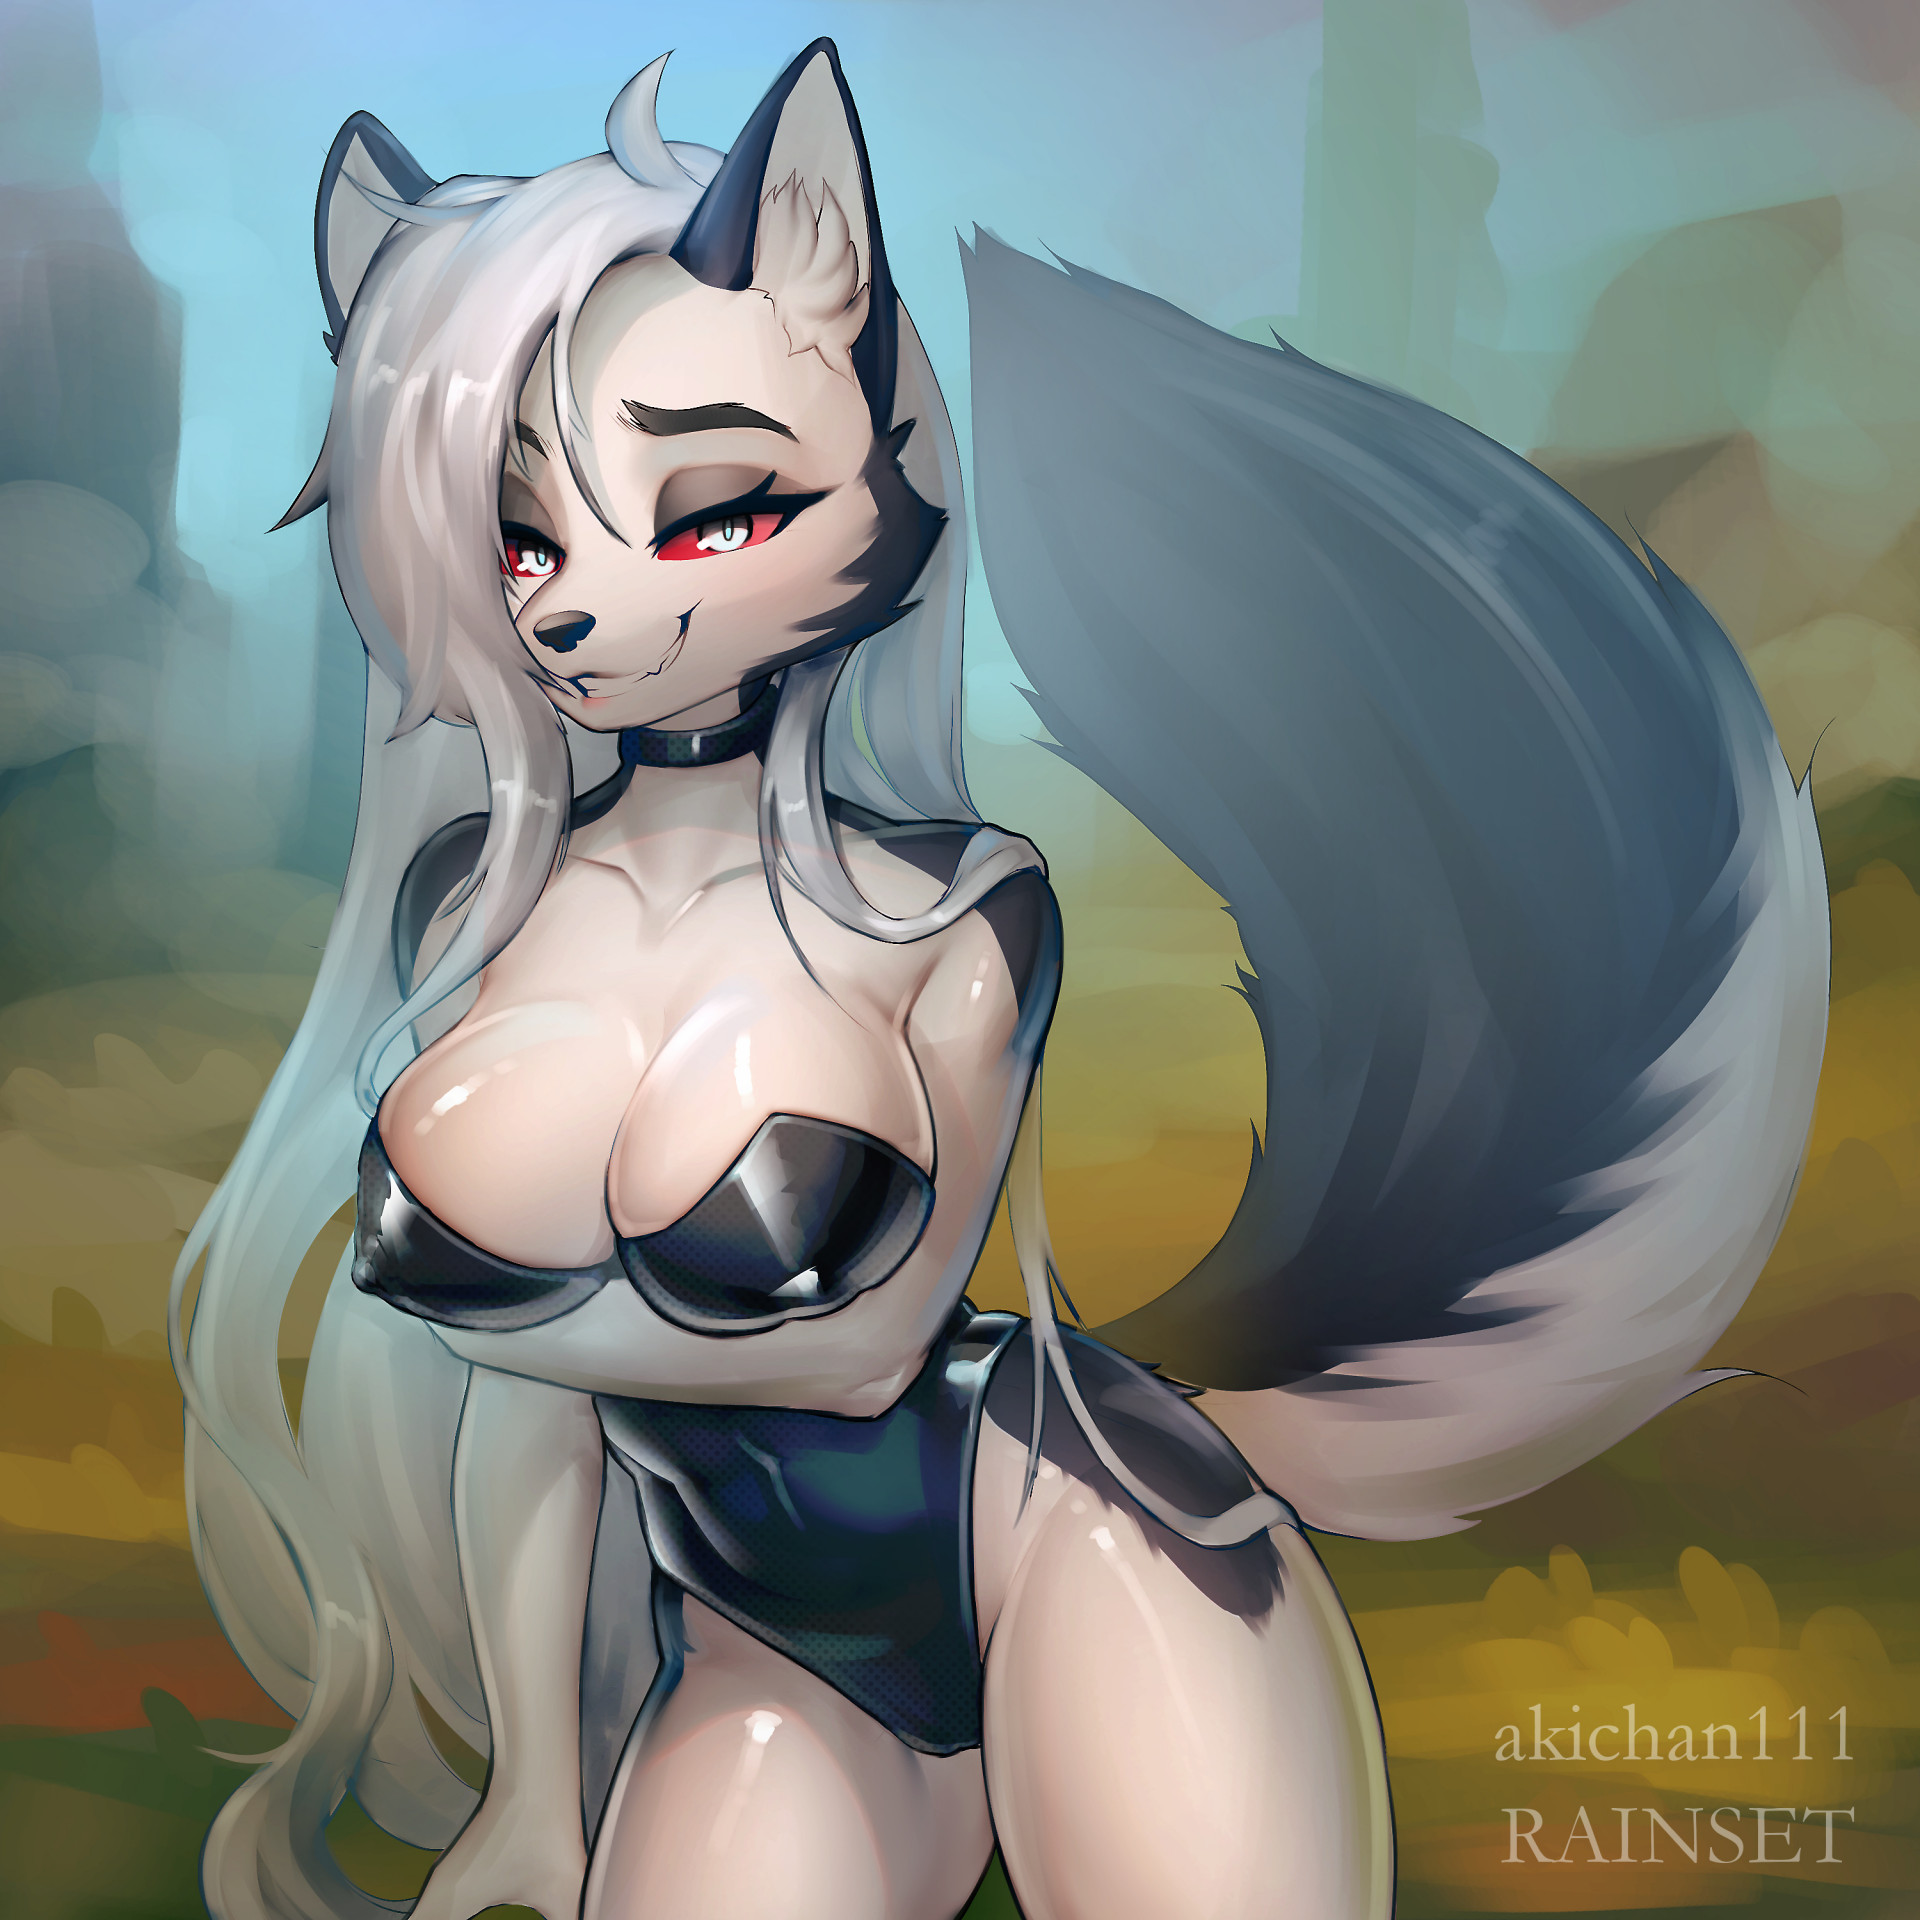

In [8]:
# Load image

image

In [9]:
type(image)

PIL.Image.Image

In [27]:
import PIL
from torchvision import transforms as T


In [ ]:
class ImageInterpolator:
	def __init__(self, cfg):
		self.image = Image.open(cfg.source_path).convert('RGB')
		self.image = image_to_tensor(self.image)
		self.image = self.normalize(self.image)

		self.shape = self.image.shape

	def __call__(self, coordinates_xy):
		"""Resives original coordinates,
			scales them to [0-1].
		"""
		coordinates_scale = torch.tensor([self.shape[1], self.shape[0]])
		coordinates_xy = coordinates_xy * coordinates_scale

		# Calculate Integer and Fractional Parts
		indices = coordinates_xy.long()
		lerp_weights = coordinates_xy - indices.float()

		# Clamp Indices to Valid Range
		x0 = indices[:, 0].clamp(min=0, max=shape[1] - 1)
		y0 = indices[:, 1].clamp(min=0, max=shape[0] - 1)
		x1 = (x0 + 1).clamp(max=shape[1] - 1)
		y1 = (y0 + 1).clamp(max=shape[0] - 1)

		# Perform Bilinear Interpolation
		output = (
			self.data[y0, x0] * (1.0 - lerp_weights[:, 0:1]) * (1.0 - lerp_weights[:, 1:2]) +
			self.data[y0, x1] * lerp_weights[:, 0:1] * (1.0 - lerp_weights[:, 1:2]) +
			self.data[y1, x0] * (1.0 - lerp_weights[:, 0:1]) * lerp_weights[:, 1:2] +
			self.data[y1, x1] * lerp_weights[:, 0:1] * lerp_weights[:, 1:2]
		)
		return output

	def image_to_tensor(self, image: PIL.Image.Image) -> torch.Tensor:
		# NOT NORMILIZED!!!
		return T.PILToTensor()(image)
	def tensor_to_image(self, t_image: torch.Tensor) -> PIL.Image.Image:
		return T.ToPILImage()(t_image)

	def normalize(self, x):
		return x / 255.0
	def denormalize(self, x):
		return x * 255


In [ ]:
# This is a much faster way of interpolating
# use with torch jit
class Image_custum(torch.nn.Module):
    def __init__(self, path, device):
        super().__init__()
        self.data = read_image(path)
        self.shape = self.data.shape
        self.data = torch.from_numpy(self.data).float().to(device)

    def forward(self, xs):
        with torch.no_grad():
            shape = self.shape
            xs = xs * torch.tensor([shape[1], shape[0]], device=xs.device).float()
            indices = xs.long()
            lerp_weights = xs - indices.float()

            x0 = indices[:, 0].clamp(min=0, max=shape[1] - 1)
            y0 = indices[:, 1].clamp(min=0, max=shape[0] - 1)
            x1 = (x0 + 1).clamp(max=shape[1] - 1)
            y1 = (y0 + 1).clamp(max=shape[0] - 1)

            return (
                    self.data[y0, x0] * (1.0 - lerp_weights[:, 0:1]) * (1.0 - lerp_weights[:, 1:2]) +
                    self.data[y0, x1] * lerp_weights[:, 0:1] * (1.0 - lerp_weights[:, 1:2]) +
                    self.data[y1, x0] * (1.0 - lerp_weights[:, 0:1]) * lerp_weights[:, 1:2] +
                    self.data[y1, x1] * lerp_weights[:, 0:1] * lerp_weights[:, 1:2]
            )


In [21]:
# Define models


In [ ]:
# Train
